# Sistema Multi-Robôs para Cobertura Eficiente de Ambientes Domésticos

- Bernardo Nogueira Borges
- Daniele Cássia Silva Diniz

Uma aplicação relevante na área de robótica é a dos robôs aspiradores, que têm a
função de percorrer o ambiente doméstico de forma autônoma, recolhendo detritos
ao longo do caminho. Este projeto abordará o problema de cobertura no contexto de
sistemas multi-robôs, com o objetivo de dividir a tarefa entre dois robôs. Um dos
principais desafios nesta área é garantir que os robôs executem seu trajeto de forma
eficiente, evitando a movimentação aleatória pelo espaço, como observado em
robôs aspiradores convencionais, conforme demonstrado no [vídeo](https://www.youtube.com/watch?v=qHEJhJ_CuOQ) da Neato
Robotics

Para superar esses desafios, utilizaremos nosso conhecimento em mapeamento,
controle e algoritmos para desenvolver um sistema de multi-robôs que abordará o
problema de **cobertura** do ambiente de forma eficaz, completa e, adicionalmente,
enfrentaremos o desafio de implementar a colaboração entre os robôs. A
implementação será realizada utilizando a linguagem **Python** e o simulador
**CoppeliaSim**.

Abordar este problema é crucial para aumentar a eficiência energética e reduzir a
pegada de carbono dos robôs aspiradores domésticos. Um planejamento adequado
permite que esses robôs executem suas tarefas de maneira mais rápida e eficiente,
contribuindo significativamente para a sustentabilidade ambiental. As principais
aplicações incluem a limpeza autônoma em residências, escritórios e outros
espaços fechados onde a manutenção regular é necessária.

In [291]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import networkx as nx
import math

client = RemoteAPIClient()
sim = client.require('sim')
np.set_printoptions(precision=3,suppress=True)

## Obtendo o Mapa da Residência

In [292]:
CREATE_PLOTS = True

#--------------------------------------------------#

# Home
figsize = (8,8)
img = 1 - mpimg.imread('./maps/home20x20.png')
dims = [10,10] # Dimensoes do mapa (m)
cell_size = 0.5  # Tamanho da celula do grid (m)

#--------------------------------------------------#


Imagem carregada


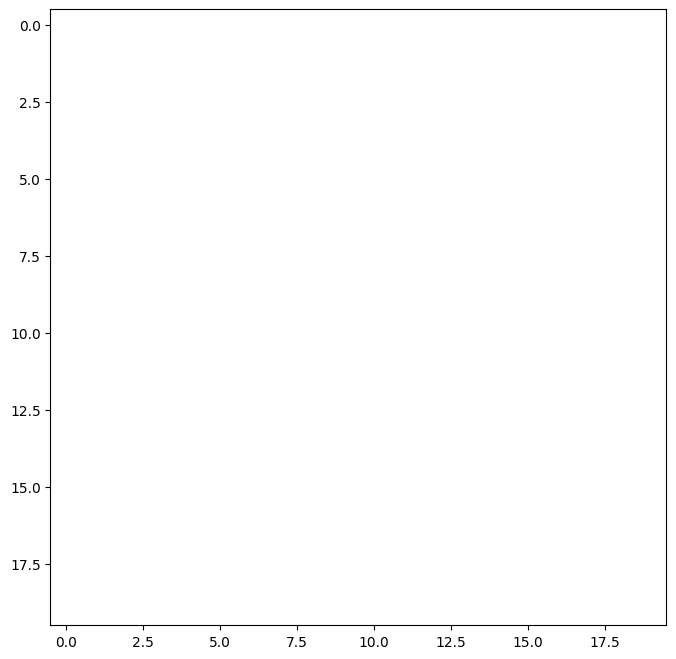

In [293]:


# Definir range x e y para a conversao de mapa-cena
sceneXrange = (10,-10) # para direita
sceneYrange = (-10,10) # para baixo

# Apenas para garantir que só teremos esses dois valores
threshold = 0.2
img[img > threshold] = 1
img[img<= threshold] = 0

# Definindo figura 
if CREATE_PLOTS:
    fig = plt.figure(figsize=figsize,dpi=100)
    ax = fig.add_subplot(111,aspect='equal')
    ax.imshow(img, cmap='Greys', origin='upper')

print("Imagem carregada")



Grid definida
20
20


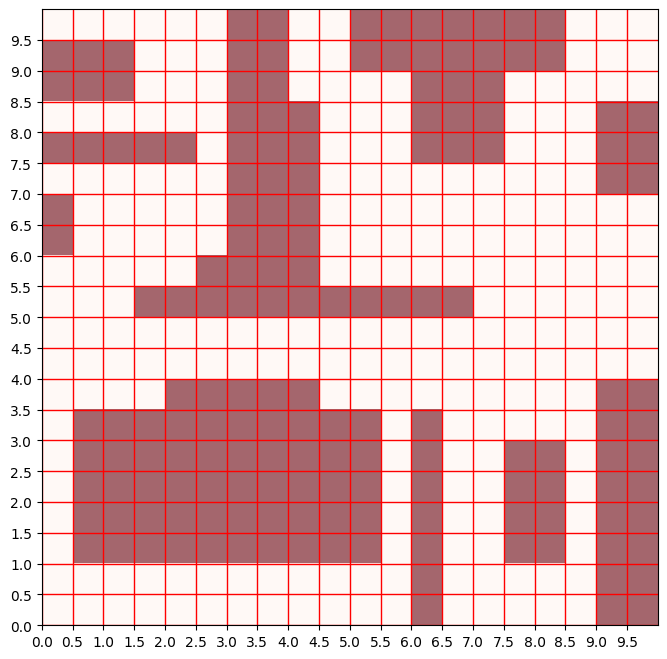

In [294]:
# Dimensões do mapa informado em metros (X, Y)
map_dims = np.array(dims)

# Escala Pixel/Metro
sy, sx = img.shape[:2] / map_dims

rows, cols = (map_dims / cell_size).astype(int)
grid = np.zeros((rows, cols))

gridXrange = (0,cols-1) # para direita
gridYrange = (0,rows-1) # para baixo


# Preenchendo o Grid
# Cada célula recebe o somatório dos valores dos Pixels
for r in range(rows):
    for c in range(cols):
        
        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)
        
        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)
                      
        grid[r, c] = np.sum(img[yi:yf,xi:xf])
        
# Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
grid[grid > threshold] = 1
grid[grid<= threshold] = 0        

if CREATE_PLOTS:
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # Plotando Mapa e Células
    obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
    obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

    # Plotando as linhas do grid para facilitar a visualização
    ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
    ax.set_xticks(np.arange(0, map_dims[1], cell_size))
    ax.set_yticks(np.arange(0, map_dims[0], cell_size))

print("Grid definida")
print(rows)
print(cols)


## Colored Planner

In [295]:
from enum import Enum


class Color(Enum):
    UNSET = 0
    RED = 1
    BLUE = 2


#          UP     RIGHT    DOWN   LEFT
moves = [(-1, 0), (0, 1), (1, 0), (0, -1)]


def validCell(i, j, G):
    N = len(G)
    M = len(G[0])
    return 0 <= i < N \
        and 0 <= j < M \
        and G[i][j] == 0

def bfs_multi(blue_src, red_src, G):
    COLOR_GRAPH = np.zeros(shape=G.shape)

    q = [blue_src, red_src]
    while q:
        (i, j, c) = q.pop(0)

        if COLOR_GRAPH[i][j] != Color.UNSET.value:
            continue

        COLOR_GRAPH[i][j] = c.value

        # Each cell 4-Connect
        for (di, dj) in moves:
            di += i
            dj += j

            # Out of bounds
            if not validCell(di, dj, G):
                continue

            # Already visited
            if COLOR_GRAPH[di][dj] != Color.UNSET.value:
                continue

            q.append((di, dj, c))

    return COLOR_GRAPH


def colorize(G):
    N = len(G)
    M = len(G[0])
    blue_src = None
    for i in range(N):
        for j in range(M):
            if G[i][j] == 0:
                blue_src = (i, j, Color.BLUE)
                break
        if blue_src != None:
            break

    if blue_src == None:
        print("Could not find a blue_src")
        return

    red_src = None
    for i in reversed(range(N)):
        for j in reversed(range(M)):
            if G[i][j] == 0 and (i, j) != (blue_src[0], blue_src[1]):
                red_src = (i, j, Color.RED)
                break
        if red_src != None:
            break

    if red_src == None:
        print("Could not find a red_src")
        return

    return bfs_multi(blue_src, red_src, G)


def plot_color_graph(CG):
    N = len(CG)
    M = len(CG[0])

    # Create a colormap with specified colors
    cmap = plt.cm.colors.ListedColormap(['gray', 'blue', 'red'])
    bounds = [-0.5, 0.5, 1.5, 2.5]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

    # Create the plot
    plt.figure(figsize=(6*(M/N), 6))
    plt.imshow(CG, cmap=cmap, norm=norm)
    plt.colorbar(ticks=[0, 1, 2])
    plt.show()

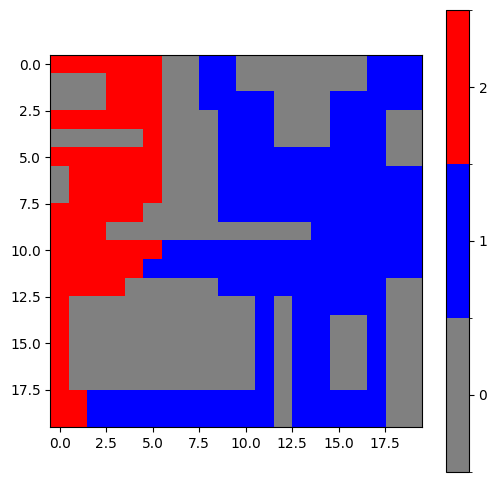

In [296]:
G=grid

CG = colorize(G)
plot_color_graph(CG)

## Localizando com os Mapas

In [297]:
cell_size = 0.5

def sceneToGrid(coords):
    sx, sy = coords
    gx = int((sx+5) / cell_size)
    gy = int((sy+5) / cell_size)
    return gx, gy

def gridToScene(coords):
    gx, gy = coords
    sx = (gx * cell_size) - 5 + (cell_size/2)
    sy = (gy * cell_size) - 5 + (cell_size/2)
    return sx, sy

## Controle

In [298]:
def deLucaOriolo(force, theta):
    kv = 1
    kw = 0.7
    Fx, Fy = force[:2]

    v = kv*(Fx*np.cos(theta) + Fy*np.sin(theta))
    w = kw*(np.arctan2(Fy, Fx) - theta)

    return [v, w]

## Iniciando os Robôs

#### Funções Auxiliares

In [299]:
def Rz(theta):
    return np.array(
        [[np.cos(theta), -np.sin(theta), 0],
         [np.sin(theta), np.cos(theta), 0],
         [0, 0, 1]])


# ! GOAL OBJECT FOR DEBUGGING
goal_object = sim.getObject("/Goal")


class Robot():
    def __init__(self, name):
        self.name = name
        self.object = sim.getObject(f"/{name}")
        self.L = 0.230
        self.r = 0.035
        self.left_motor = sim.getObject(f"/{name}/kobuki_leftMotor")
        self.right_motor = sim.getObject(f"/{name}/kobuki_rightMotor")
        self.set_target_velocity(0, 0)

        self.ERROR_MARGIN = 0.05
        self.next_goals = []
        self.current_goal = None

    def differentialModel(self,v, w):
        wr = ((2.0*v) + (w*self.L))/(2.0*self.r)
        wl = ((2.0*v) - (w*self.L))/(2.0*self.r)
        return [wl, wr]

    def set_target_velocity(self, wl, wr):
        sim.setJointTargetVelocity(self.left_motor, wl)
        sim.setJointTargetVelocity(self.right_motor, wr)

    def get_current_position(self):
        pos = sim.getObjectPosition(self.object)
        ori = sim.getObjectOrientation(self.object)
        q = np.array([pos[0], pos[1], ori[2]])
        return q

    def get_current_location(self):
        q = self.get_current_position() # + cell_size * np.array([0.5, 0.5, 0])
        return sceneToGrid(q[:2])

    def get_current_goal(self):
        if self.current_goal != None:
            return self.current_goal
        if len(self.next_goals) > 0:
            self.current_goal = self.next_goals.pop(0)
            print(f"[{self.name}] new goal is {self.current_goal}")
            (jg, ig) = self.current_goal
            (xg, yg) = gridToScene((jg, ig))
            q_goal = np.array([xg, yg, 0]) # + np.array([0.0, 0.2, 0])
            sim.setObjectPosition(goal_object, [(q_goal[0]), (q_goal[1]), .2])
            print(f"set goal at {q_goal[0]} {q_goal[1]}")
            return self.current_goal
        return None

    def get_goal_location(self):
        return self.current_goal

    def get_goal_position(self):
        (jg, ig) = self.current_goal
        (xg, yg) = gridToScene((jg, ig))
        # Goal should be in the middle of cell
        q_goal = np.array([xg, yg, 0]) # + np.array([0.0, 0.2, 0])
        return q_goal

    def add_new_goals(self, new_goals):
        self.next_goals.extend(new_goals)

    def has_reached_goal(self):
        if self.current_goal == None:
            return True

        q = self.get_current_position()
        q_goal = self.get_goal_position()
        error = q_goal - q
        return np.linalg.norm(error[:2]) < self.ERROR_MARGIN

    def move_to_goal(self):
        """
        Returns True if no goal left
        """
        if self.get_current_goal() == None:
            print(f"[{self.name}] has no goals.")
            return True

        if self.has_reached_goal():
            print(f"[{self.name}] has reached goal {self.current_goal}")
            # if no new goal,
            if not self.next_goals:
                print(f"[{self.name}] has no new goals.")
                self.current_goal = None
                self.set_target_velocity(0, 0)
                return False

            # find new goal
            self.current_goal = self.next_goals.pop(0)

            # ! DEBUG
            q_goal = self.get_goal_position()
            sim.setObjectPosition(goal_object, [(q_goal[0]), (q_goal[1]), .2])
            print(f"set goal at {q_goal[0]} {q_goal[1]}")

            print(f"[{self.name}] new goal is {self.current_goal}")
            print(f"[{self.name}] is at {self.get_current_location()}")

        # TODO: Potential fields to reach current_goal
        q = self.get_current_position()
        q_goal = self.get_goal_position()
        katt = 0.3
        force = katt * (q_goal - q)
        
        # Calculate the magnitude of the vector
        # normalized_force = force / np.linalg.norm(force)

        theta = sim.getObjectOrientation(self.object)[2]

        # Controle Cinematico
        [v,w] = deLucaOriolo(force,theta)
        # Cinematica inversa
        [wl,wr] = self.differentialModel(v,w)

        self.set_target_velocity(wl,wr)
        return False
    



#### WALL-E

In [300]:
# walle = Robot("WALL_E")
walle = Robot("kobuki")
print(walle.name, walle.object, walle.left_motor, walle.right_motor)
print(walle.get_current_location())
(rj,ri) = walle.get_current_location()
print(CG[ri][rj])



kobuki 116 128 133
(8, 18)
1.0


#### M-O

In [301]:
# mo = Robot("M_O")
mo = Robot("kobuki")
print(mo.name, mo.object, mo.left_motor, mo.right_motor)
print(mo.get_current_location())

(rj,ri) = mo.get_current_location()
print(CG[ri][rj])


kobuki 116 128 133
(8, 18)
1.0


## Controle para andar entre células

## Simulação

In [302]:
sim.stopSimulation()
sim.startSimulation()

MAX_SIMULATION_TIME = 600

# walle.add_new_goals([(15,15),(15,14),(15,13),(15,12),(14,12),(14,11)])
walle.add_new_goals([(8,18),(8,17),(8,16),(8,15),(8,14),(8,13),(8,12),
                     (9,12),(9,13),(9,14)])

while (t := sim.getSimulationTime()) < MAX_SIMULATION_TIME:
    no_goal = walle.move_to_goal()
    if no_goal:
        break
    # break
    # mo.move_to_goal()
    sim.step()

sim.stopSimulation()

[kobuki] new goal is (8, 18)
set goal at -0.75 4.25
[kobuki] has reached goal (8, 18)
set goal at -0.75 3.75
[kobuki] new goal is (8, 17)
[kobuki] is at (8, 18)
[kobuki] has reached goal (8, 17)
set goal at -0.75 3.25
[kobuki] new goal is (8, 16)
[kobuki] is at (8, 17)
[kobuki] has reached goal (8, 16)
set goal at -0.75 2.75
[kobuki] new goal is (8, 15)
[kobuki] is at (8, 16)
[kobuki] has reached goal (8, 15)
set goal at -0.75 2.25
[kobuki] new goal is (8, 14)
[kobuki] is at (8, 15)
[kobuki] has reached goal (8, 14)
set goal at -0.75 1.75
[kobuki] new goal is (8, 13)
[kobuki] is at (8, 14)
[kobuki] has reached goal (8, 13)
set goal at -0.75 1.25
[kobuki] new goal is (8, 12)
[kobuki] is at (8, 13)
[kobuki] has reached goal (8, 12)
set goal at -0.25 1.25
[kobuki] new goal is (9, 12)
[kobuki] is at (8, 12)
[kobuki] has reached goal (9, 12)
set goal at -0.25 1.75
[kobuki] new goal is (9, 13)
[kobuki] is at (9, 12)
[kobuki] has reached goal (9, 13)
set goal at -0.25 2.25
[kobuki] new goal i